We perform topic modeling using gensim
Topic modelling is unsupervised learning to discover the latent topics that occur in the HWZ threads


# Import scrape file

In [1]:
import os
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Practice module NLP/PLP Practice Module/hwz")

Mounted at /content/gdrive


In [2]:
!pip install emoji

     |████████████████████████████████| 170 kB 6.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=1077af687959ed8d52839f97567adb80c77bf5140735b00283f698595d6a4370
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [24]:
import numpy as np
import pandas as pd
import emoji
import datetime

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, words

import re
import pickle
import logging
import gensim 
from gensim import corpora

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

!pip install pyLDAvis==2.1.2
import pyLDAvis
import pyLDAvis.gensim as gensimvis

from gensim.matutils import corpus2csc, sparse2full, corpus2dense


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


#Preprocessing

Get latest 10 posts of each thread

In [25]:
df=pd.read_csv('data_remove.csv', index_col=0)
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].apply(lambda x: x.strftime("%Y"))
df['month'] = df['datetime'].apply(lambda x: x.strftime("%m"))
df['day'] = df['datetime'].apply(lambda x: x.strftime("%d"))
df['year'] = df['year'].apply(int)
df['month'] = df['month'].apply(int)
df['day'] = df['day'].apply(int)
df = df.drop(df[df.content.isnull()].index)
df = df[df.year == 2021]
df = df[df.month <= 10]
df.reset_index(inplace=True)
df=df.sort_values(by=['datetime'], ascending=True)
df=df.groupby('url').head(10).reset_index()
df=df.groupby(['url'], as_index = False).agg({'content':' '.join})

Remove URL link

In [26]:
def remove_urls(text):
  url_pattern = re.compile(r'http\S+', flags=re.M)
  return url_pattern.sub("", text)

Get lemmas of noun and plural nouns

In [27]:
#only noun can have lemmas
# pronouns are names of places, ppl
def lemmaNVAR(wpos):
    lemmas = []
    for w, pos in wpos:
        if pos[0] in ('N'): #noun start with N, adverb start with R, adjective start with J
            if pos in ('NNS'): #words with inflexion(-ed, -ing, -s) that need lemmatization, focus on plural noun not singluar noun
                lemmas.append(WNlemma.lemmatize(w.lower(), pos = pos[0].lower())) #case lowering and take first position of pos
    return lemmas

Preprocessing to remove stopwords and create tokens

In [28]:
WNlemma = nltk.WordNetLemmatizer()
covidwords = ['covid', 'covid19','covid 19','covid-19','coronavirus','corona','china virus', 'virus',
              'precovid', 'precovid19','precovid 19','precovid-19',
              'pre-covid', 'pre-covid19','pre-covid 19','pre-covid-19',
              'postcovid', 'postcovid19','postcovid 19','postcovid-19',
              'post-covid', 'post-covid19','post-covid 19','post-covid-19']

mystopwords = stopwords.words("english") + ['click','to','expand','edmwer','app','...','say', 'like', 'one','also','still', "n't", "already","liao","straitstimes.com","www.straitstimes.com","people"] + covidwords
words = set(words.words())

def pre_process_1(text):
    text = str(text)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',"",text)
    text = re.sub("\{[^}]*\}","",text)
    text = re.sub(r'(https|http|ftp)://([\w_]+(?:(?:\.[\w_-]+))[\w_.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', "", text) #remove url link
    text = remove_urls(text)
    text = emoji.demojize(text)
    tokens = lemmaNVAR(pos_tag(word_tokenize(text)))
    tokens = [ t for t in tokens if t in words]
    tokens=[ t for t in tokens if t not in mystopwords]
    tokens = [ t for t in tokens if len(t) >= 3 ]
 
    return tokens


In [29]:
content = df['content']

tokens = content.apply(pre_process_1)

print(content,'\n\n')
print(tokens)

0        A Marin County woman, who was fully vaccinated...
1        独家爆料：“我在新加坡打完辉瑞后，被送进了重症监护室......”\n\t\t\t\t\t\...
2        Wad rubbish is dis \n\ngov putting their peopl...
3        if you think you will get back your freedom af...
4        Gong wu Gong Boh at is best... you and your co...
                               ...                        
10593    can’t imagine the agony, pain and lost of thei...
10594    Thats Good Next time those SJW accounts JJWW p...
10595    Opps-gal said:\n\n\n\n\t\t\tWhose fault?\n\t\t...
10596    Phantosmia?\n\nno wonder. So this is the condi...
10597    Bolder carrot-and-stick approach needed to acc...
Name: content, Length: 10598, dtype: object 


0        [woman, victim, friend, painter, singer, busin...
1        [video, link, sent, day, min, day, bit, eviden...
2        [rubbish, couple, reason, responsibility, coun...
3        [freedom, granny, mother, earth, freedom, gran...
4        [colleague, peasant, money, stubbornness, wave...
         

In [30]:
# with open('tokensv2.pickle', 'wb') as handle:
#   pickle.dump(tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('tokensv2.pickle', 'rb') as handle:
  tokens = pickle.load(handle)

## Check frequency of words

In [31]:
# Check most frequent words 
from collections import Counter

cnt = Counter()

for text in tokens:
    for word in text:
        cnt[word] += 1
        
cnt.most_common(100)

[('case', 12382),
 ('vaccine', 11005),
 ('country', 5061),
 ('time', 4945),
 ('day', 4857),
 ('year', 4457),
 ('vaccination', 4235),
 ('infection', 3941),
 ('death', 3934),
 ('test', 3763),
 ('variant', 3758),
 ('number', 3411),
 ('week', 2789),
 ('home', 2673),
 ('patient', 2586),
 ('month', 2574),
 ('risk', 2414),
 ('world', 2354),
 ('health', 2212),
 ('mask', 2080),
 ('hospital', 2061),
 ('cluster', 2012),
 ('rate', 1954),
 ('government', 1935),
 ('symptom', 1913),
 ('need', 1889),
 ('data', 1848),
 ('population', 1803),
 ('community', 1773),
 ('news', 1770),
 ('worker', 1737),
 ('study', 1667),
 ('thing', 1629),
 ('expert', 1622),
 ('cent', 1611),
 ('disease', 1608),
 ('way', 1608),
 ('measure', 1597),
 ('family', 1587),
 ('shot', 1556),
 ('place', 1551),
 ('group', 1551),
 ('jab', 1545),
 ('life', 1507),
 ('result', 1457),
 ('effect', 1393),
 ('doctor', 1349),
 ('report', 1318),
 ('everyone', 1295),
 ('pandemic', 1291),
 ('care', 1255),
 ('work', 1218),
 ('dose', 1217),
 ('staff',

# Modelling for 5 topics

In [32]:
data_ready = tokens
frac = 0.5
num_topics = 5
passes = 5
chunksize = 32
random_state=99

# Use dictionary (built from corpus) to prepare a DTM (using frequency)

#df = dataframe.sample(frac = frac, random_state=random_state)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Filter off any words with document frequency less than 2, or appearing in more than 80% documents
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]

2021-11-22 23:46:35,091 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 23:46:35,502 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-22 23:46:35,523 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-22 23:46:35,544 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('homeland', 9), ('brainwashing', 2), ('granny', 3), ('stubbornness', 6), ('competitor', 8), ('comrade', 7), ('interviewee', 2)]...
2021-11-22 23:46:35,546 : INFO : keeping 1879 tokens which were in no less than 20 and no more than 8478 (=80.0%) documents
2021-11-22 23:46:35,552 : INFO : resulting dictionary: Dictionary(1879 unique tokens: ['business', 'friend', 'report', 'victim', 'woman']...)


In [33]:
lda_5 = gensim.models.ldamodel.LdaModel(dtm, num_topics = num_topics, id2word = dictionary, passes=passes,chunksize=chunksize,random_state=random_state)

Streaming output truncated to the last 5000 lines.
2021-11-22 23:47:33,213 : INFO : PROGRESS: pass 3, at document #1536/10598
2021-11-22 23:47:33,232 : INFO : merging changes from 32 documents into a model of 10598 documents
2021-11-22 23:47:33,237 : INFO : topic #0 (0.200): 0.032*"year" + 0.029*"time" + 0.014*"country" + 0.013*"life" + 0.013*"report" + 0.012*"government" + 0.012*"month" + 0.012*"child" + 0.011*"world" + 0.011*"way"
2021-11-22 23:47:33,242 : INFO : topic #1 (0.200): 0.039*"test" + 0.026*"cluster" + 0.024*"mask" + 0.019*"home" + 0.019*"day" + 0.017*"staff" + 0.016*"contact" + 0.015*"quarantine" + 0.014*"school" + 0.014*"worker"
2021-11-22 23:47:33,245 : INFO : topic #2 (0.200): 0.096*"vaccine" + 0.044*"vaccination" + 0.039*"variant" + 0.031*"death" + 0.022*"population" + 0.021*"country" + 0.019*"rate" + 0.015*"shot" + 0.015*"jab" + 0.014*"data"
2021-11-22 23:47:33,249 : INFO : topic #3 (0.200): 0.037*"patient" + 0.030*"study" + 0.029*"symptom" + 0.023*"hospital" + 0.018

In [83]:
#  with open('lda_5v2.pickle', 'wb') as handle:
#     pickle.dump(lda_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

Top 10 representative words for 5 topics

In [34]:
lda_5.show_topics(10)

[(0,
  '0.034*"year" + 0.025*"time" + 0.024*"smell" + 0.020*"child" + 0.013*"country" + 0.012*"life" + 0.011*"month" + 0.011*"sense" + 0.010*"report" + 0.010*"world"'),
 (1,
  '0.048*"test" + 0.027*"home" + 0.025*"worker" + 0.022*"mask" + 0.019*"cluster" + 0.018*"food" + 0.014*"day" + 0.014*"school" + 0.011*"job" + 0.011*"staff"'),
 (2,
  '0.098*"vaccine" + 0.062*"variant" + 0.044*"vaccination" + 0.023*"country" + 0.023*"death" + 0.016*"rate" + 0.015*"population" + 0.015*"data" + 0.014*"expert" + 0.014*"jab"'),
 (3,
  '0.052*"patient" + 0.029*"study" + 0.026*"doctor" + 0.026*"symptom" + 0.017*"effect" + 0.017*"hospital" + 0.016*"body" + 0.016*"disease" + 0.015*"taste" + 0.015*"drug"'),
 (4,
  '0.216*"case" + 0.049*"number" + 0.044*"infection" + 0.042*"day" + 0.031*"community" + 0.026*"week" + 0.016*"wave" + 0.015*"today" + 0.014*"senior" + 0.013*"arrival"')]

In [36]:
'''
u_mass:prefer the model close to 0
c_v: [0,1], prefer bigger value
Do not fully rely on the coherence score
'''

from gensim.models.coherencemodel import CoherenceModel

dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=2, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]


cm_umass = CoherenceModel(lda_5,  dictionary=dictionary, corpus=dtm, coherence='u_mass')
cm_cv = CoherenceModel(lda_5,  dictionary=dictionary, texts=tokens, coherence='c_v')
lda_5_umass = cm_umass.get_coherence()
lda_5_cv = cm_cv.get_coherence()
print(f"u_mass:{lda_5_umass}",'\n\n')
print(f"cv:{lda_5_cv}")

2021-11-22 23:54:10,906 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 23:54:11,308 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-22 23:54:11,330 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-22 23:54:11,345 : INFO : discarding 2931 tokens: [('painter', 1), ('striking', 1), ('dow', 1), ('cushion', 1), ('dishwashing', 1), ('fieldwork', 1), ('appeasement', 1), ('aghast', 1), ('bangle', 1), ('punter', 1)]...
2021-11-22 23:54:11,347 : INFO : keeping 6630 tokens which were in no less than 2 and no more than 8478 (=80.0%) documents
2021-11-22 23:54:11,357 : INFO : resulting dictionary: Dictionary(6630 unique tokens: ['business', 'friend', 'report', 'singer', 'victim']...)
2021-11-22 23:54:11,889 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021

u_mass:-9.10533638568538 


cv:0.45287028371827687


##Visualise 5 topics

In [37]:
data_ready = tokens
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
dtm = [dictionary.doc2bow(d) for d in data_ready]
# Build LDA model
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_5, dtm, dictionary=lda_5.id2word)
vis

     |████████████████████████████████| 1.6 MB 8.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=bb34dbd1fe5988b14bcf6e6e8d15a0438591234cc68c8a2293d3de1ee93d64fb
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


2021-11-22 23:54:38,011 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2021-11-22 23:54:38,038 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
2021-11-22 23:54:38,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 23:54:38,597 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-22 23:54:38,618 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-22 23:54:38,639 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.282550  0.103391       1        1  26.176339
2     -0.100392 -0.112112       2        1  24.737165
1     -0.015308  0.184247       3        1  20.760376
3      0.080434 -0.322534       4        1  14.687227
4      0.317816  0.147007       5        1  13.638893, topic_info=            Term          Freq         Total Category  logprob  loglift
78          case  12289.000000  12289.000000  Default  30.0000  30.0000
14       vaccine  10116.000000  10116.000000  Default  29.0000  29.0000
243      variant   6432.000000   6432.000000  Default  28.0000  28.0000
107  vaccination   4510.000000   4510.000000  Default  27.0000  27.0000
180      patient   3191.000000   3191.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
126      measure    510.356261   1396.283662   Topic5  -4.7156   0.9858
233        place    496.269927   1653.556554   Topic5  -4.7436   0.7887
50          news    471.417032   1753.142388   Topic5  -4.7950   0.6788
192         time    574.811937   4590.114709   Topic5  -4.5967  -0.0854
19       country    564.837965   4349.048705   Topic5  -4.6142  -0.0489

[279 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76        1  0.977876    account
76        2  0.021445    account
1176      3  0.998539    airport
77        4  0.998496   antibody
145       2  0.999516     anyone
...     ...       ...        ...
190       1  0.834038       year
190       2  0.107509       year
190       4  0.051398       year
190       5  0.006958       year
304       1  0.998580  yesterday

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [38]:
pyLDAvis.save_html(vis, 'ldav2.html')

In [39]:
def translateLdaIdx(myLdaModel, myLdaViz):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    ldaVizIdx = myLdaViz[0].index
    return list(ldaVizIdx)

In [40]:
newIdx_5 = translateLdaIdx(lda_5,vis)
newIdx_5

[0, 2, 1, 3, 4]

In [41]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    """Transform corpus to dataframe with topics matching lda visualization"""
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['topic' + str(i + 1) for i in range(numTopics)]
    return mySortedDf

In [43]:
kagDf = createDenseMat(lda_5,dtm,newIdx_5)

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [44]:
print(kagDf)

         topic1    topic2    topic3    topic4    topic5
0      0.599597  0.028571  0.029013  0.314248  0.028571
1      0.156975  0.198757  0.486084  0.014781  0.143403
2      0.258375  0.635382  0.029781  0.000000  0.071681
3      0.413202  0.192319  0.204007  0.172031  0.018441
4      0.371017  0.014567  0.157056  0.014286  0.443075
...         ...       ...       ...       ...       ...
10593  0.372758  0.000000  0.000000  0.246493  0.375052
10594  0.277294  0.128743  0.546802  0.020524  0.026638
10595  0.032919  0.511897  0.065907  0.049323  0.339954
10596  0.424996  0.043006  0.069906  0.416542  0.045550
10597  0.340336  0.287640  0.140646  0.156498  0.074880

[10598 rows x 5 columns]


In [45]:
topic_number = kagDf.idxmax(axis=1)

In [46]:
result = pd.concat([df,topic_number], axis=1, join='inner')
result.head

<bound method NDFrame.head of                                                      url  ...       0
0      " Extreme Rare " A Marin County woman, who was...  ...  topic1
1      "4 days after the covid-19 jab, being sent to ...  ...  topic3
2      "Americans First": US Defends Export Ban On Co...  ...  topic2
3      "Climate Lockdown" after Covid lockdown, no mo...  ...  topic1
4      "Covid19 has challenged us. But it also brough...  ...  topic5
...                                                  ...  ...     ...
10593  🙏 Malaysia news: 41 children died from Covid t...  ...  topic5
10594  🚖 Private-hire drivers, COVID-19 test provider...  ...  topic3
10595  🚨😷 [Straits Times] Delta most prevalent Covid-...  ...  topic2
10596  🤥👃 Distorted, bizarre food smells haunt Covid-...  ...  topic1
10597  🥕🥢 Bolder carrot-and-stick approach needed to ...  ...  topic1

[10598 rows x 3 columns]>

In [47]:
result.to_csv('topic_model_5v2.csv')

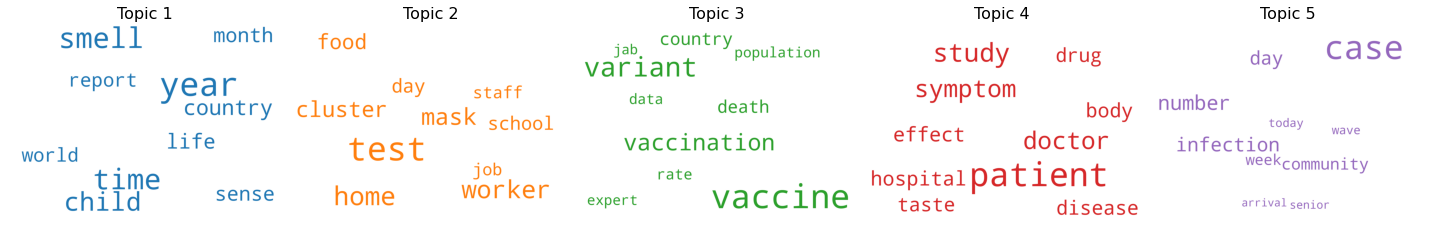

In [54]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=mystopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_5.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [55]:
data_ready = tokens
from collections import Counter
topics = lda_5.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
  for word, weight in topic:
    out.append([word, i , weight, counter[word]])


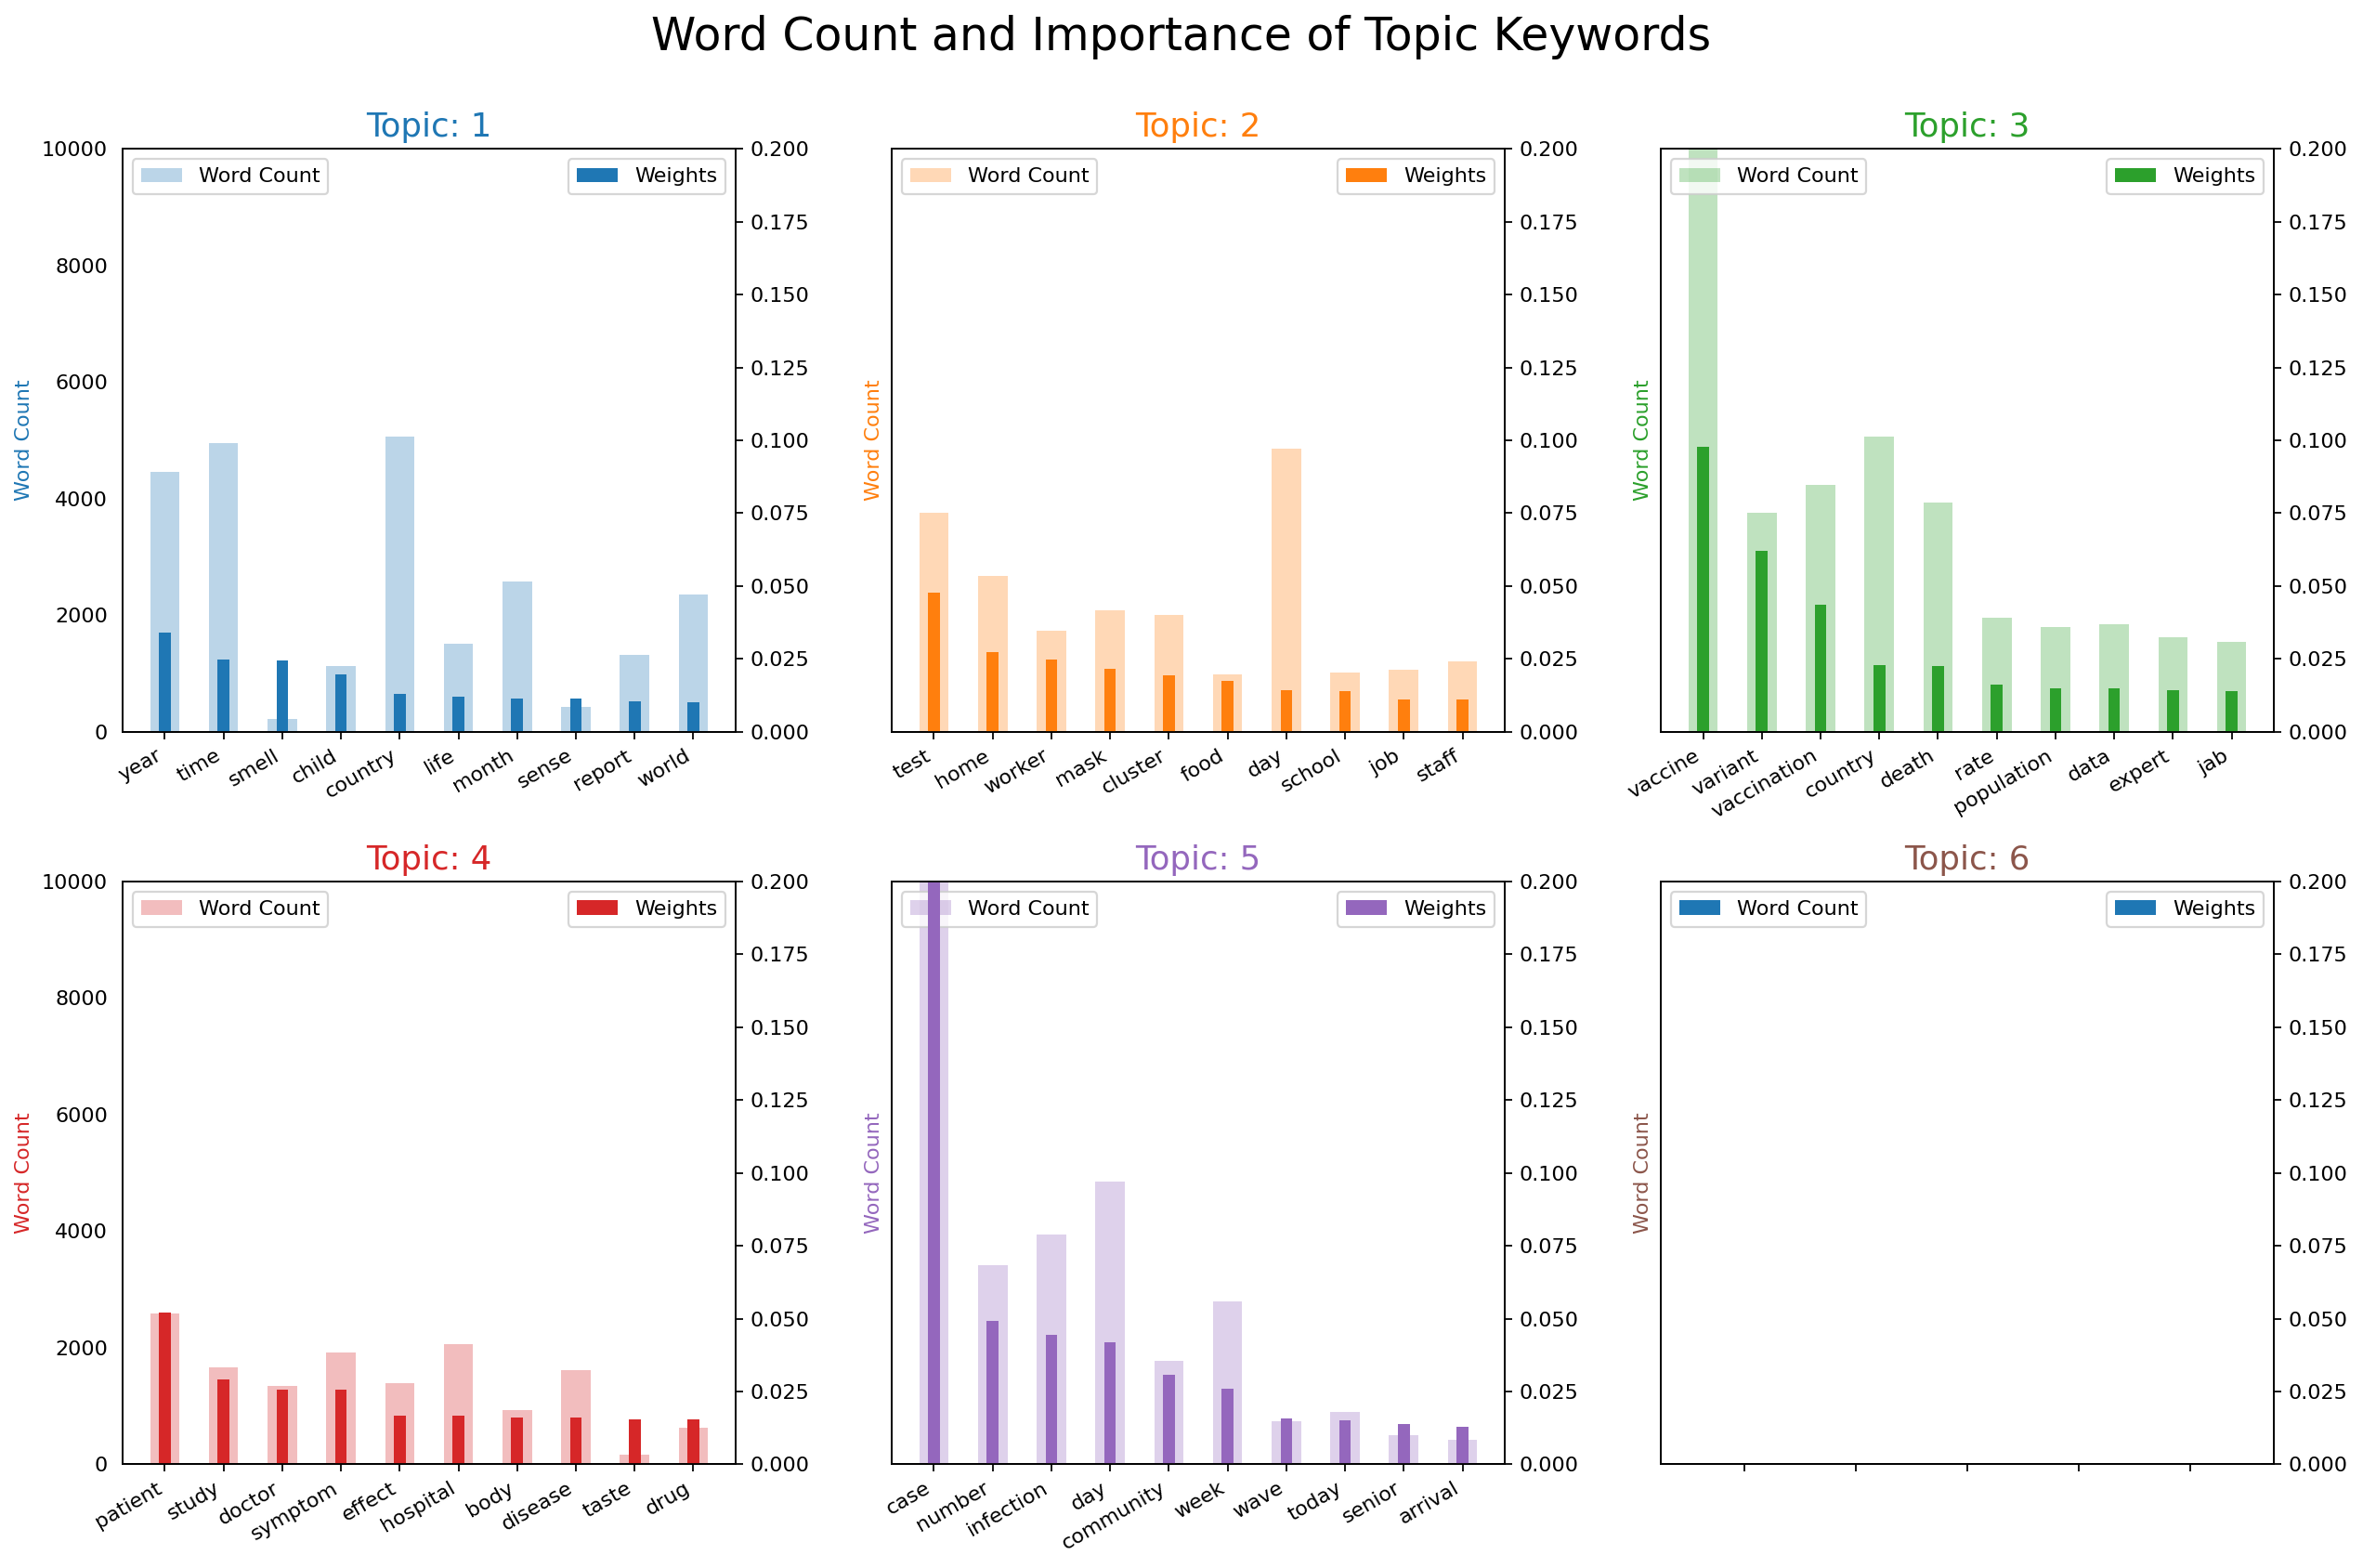

In [63]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i])
  ax_twin.set_ylim(0, 0.20); ax.set_ylim(0, 10000)
  ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Modelling for 4 topics

In [64]:
data_ready = tokens
frac = 0.5
num_topics = 4
passes = 5
chunksize = 32
random_state=99

# Use dictionary (built from corpus) to prepare a DTM (using frequency)

#df = dataframe.sample(frac = frac, random_state=random_state)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Filter off any words with document frequency less than 2, or appearing in more than 80% documents
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]

2021-11-23 00:17:43,925 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:17:44,334 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:17:44,368 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:17:44,385 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('homeland', 9), ('brainwashing', 2), ('granny', 3), ('stubbornness', 6), ('competitor', 8), ('comrade', 7), ('interviewee', 2)]...
2021-11-23 00:17:44,387 : INFO : keeping 1879 tokens which were in no less than 20 and no more than 8478 (=80.0%) documents
2021-11-23 00:17:44,394 : INFO : resulting dictionary: Dictionary(1879 unique tokens: ['business', 'friend', 'report', 'victim', 'woman']...)


In [65]:
lda_4 = gensim.models.ldamodel.LdaModel(dtm, num_topics = num_topics, id2word = dictionary, passes=passes,chunksize=chunksize,random_state=random_state)

Streaming output truncated to the last 5000 lines.
2021-11-23 00:18:48,299 : INFO : PROGRESS: pass 3, at document #9536/10598
2021-11-23 00:18:48,314 : INFO : merging changes from 32 documents into a model of 10598 documents
2021-11-23 00:18:48,319 : INFO : topic #0 (0.250): 0.028*"country" + 0.023*"time" + 0.023*"year" + 0.014*"world" + 0.011*"mask" + 0.011*"government" + 0.009*"way" + 0.009*"life" + 0.009*"need" + 0.008*"pandemic"
2021-11-23 00:18:48,324 : INFO : topic #1 (0.250): 0.034*"test" + 0.023*"home" + 0.018*"day" + 0.014*"cluster" + 0.013*"measure" + 0.013*"thing" + 0.013*"job" + 0.013*"video" + 0.012*"mask" + 0.012*"result"
2021-11-23 00:18:48,328 : INFO : topic #2 (0.250): 0.106*"vaccine" + 0.042*"variant" + 0.034*"vaccination" + 0.018*"shot" + 0.017*"data" + 0.016*"study" + 0.013*"risk" + 0.013*"immunity" + 0.013*"strain" + 0.013*"health"
2021-11-23 00:18:48,331 : INFO : topic #3 (0.250): 0.135*"case" + 0.044*"death" + 0.036*"day" + 0.035*"infection" + 0.034*"number" + 0.

Top 10 representative words for 4 topics

In [66]:
lda_4.show_topics(10)

[(0,
  '0.027*"year" + 0.023*"country" + 0.022*"time" + 0.015*"child" + 0.013*"world" + 0.010*"government" + 0.010*"life" + 0.009*"need" + 0.009*"way" + 0.009*"everyone"'),
 (1,
  '0.040*"test" + 0.023*"home" + 0.022*"worker" + 0.018*"day" + 0.015*"food" + 0.013*"place" + 0.012*"measure" + 0.012*"school" + 0.011*"cluster" + 0.010*"case"'),
 (2,
  '0.095*"vaccine" + 0.060*"variant" + 0.042*"vaccination" + 0.020*"study" + 0.018*"effect" + 0.015*"risk" + 0.013*"jab" + 0.013*"data" + 0.012*"group" + 0.011*"month"'),
 (3,
  '0.134*"case" + 0.041*"patient" + 0.039*"infection" + 0.035*"smell" + 0.033*"number" + 0.031*"death" + 0.029*"day" + 0.020*"hospital" + 0.020*"symptom" + 0.017*"doctor"')]

In [85]:
#  with open('lda_4v2.pickle', 'wb') as handle:
#     pickle.dump(lda_4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
'''
u_mass:prefer the model close to 0
c_v: [0,1], prefer bigger value
Do not fully rely on the coherence score
'''

from gensim.models.coherencemodel import CoherenceModel

dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=2, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]


cm_umass = CoherenceModel(lda_4,  dictionary=dictionary, corpus=dtm, coherence='u_mass')
cm_cv = CoherenceModel(lda_4,  dictionary=dictionary, texts=tokens, coherence='c_v')
lda_4_umass = cm_umass.get_coherence()
lda_4_cv = cm_cv.get_coherence()
print(f"u_mass:{lda_4_umass}",'\n\n')
print(f"cv:{lda_4_cv}")

2021-11-23 00:33:57,760 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:33:58,168 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:33:58,190 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:33:58,203 : INFO : discarding 2931 tokens: [('painter', 1), ('striking', 1), ('dow', 1), ('cushion', 1), ('dishwashing', 1), ('fieldwork', 1), ('appeasement', 1), ('aghast', 1), ('bangle', 1), ('punter', 1)]...
2021-11-23 00:33:58,205 : INFO : keeping 6630 tokens which were in no less than 2 and no more than 8478 (=80.0%) documents
2021-11-23 00:33:58,214 : INFO : resulting dictionary: Dictionary(6630 unique tokens: ['business', 'friend', 'report', 'singer', 'victim']...)
2021-11-23 00:33:58,548 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021

u_mass:-9.506497974706509 


cv:0.47487951657782745


##Visualise 4 topics

In [68]:
data_ready = tokens
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
dtm = [dictionary.doc2bow(d) for d in data_ready]
# Build LDA model

# Build LDA model
pyLDAvis.enable_notebook()
vis2 = gensimvis.prepare(lda_4, dtm, dictionary=lda_4.id2word)
vis2

2021-11-23 00:34:14,294 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:34:14,710 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:34:14,733 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:34:14,750 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('homeland', 9), ('brainwashing', 2), ('granny', 3), ('stubbornness', 6), ('competitor', 8), ('comrade', 7), ('interviewee', 2)]...
2021-11-23 00:34:14,752 : INFO : keeping 1879 tokens which were in no less than 20 and no more than 8478 (=80.0%) documents
2021-11-23 00:34:14,758 : INFO : resulting dictionary: Dictionary(1879 unique tokens: ['business', 'friend', 'report', 'victim', 'woman']...)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.280150 -0.164191       1        1  32.727805
2     -0.109985  0.209839       2        1  23.975907
1      0.231175 -0.216893       3        1  23.447353
3      0.158961  0.171245       4        1  19.848936, topic_info=            Term          Freq         Total Category  logprob  loglift
78          case  12147.000000  12147.000000  Default  30.0000  30.0000
14       vaccine   9509.000000   9509.000000  Default  29.0000  29.0000
243      variant   6043.000000   6043.000000  Default  28.0000  28.0000
107  vaccination   4240.000000   4240.000000  Default  27.0000  27.0000
180      patient   3377.000000   3377.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
81       disease    585.950027   1373.327066   Topic4  -4.9527   0.7653
175          man    502.448443    888.583614   Topic4  -5.1064   1.0469
546      cluster    557.925338   1659.833425   Topic4  -5.0017   0.5268
192         time    594.091747   4666.437394   Topic4  -4.9389  -0.4441
205       person    518.539265   1425.585480   Topic4  -5.0749   0.6057

[239 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
76        1  0.997805   account
1176      3  0.996290   airport
445       2  0.997511  analysis
77        2  0.998613  antibody
214       1  0.989613  anything
...     ...       ...       ...
45        2  0.160077     world
190       1  0.812094      year
190       2  0.113754      year
190       3  0.015167      year
190       4  0.059152      year

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

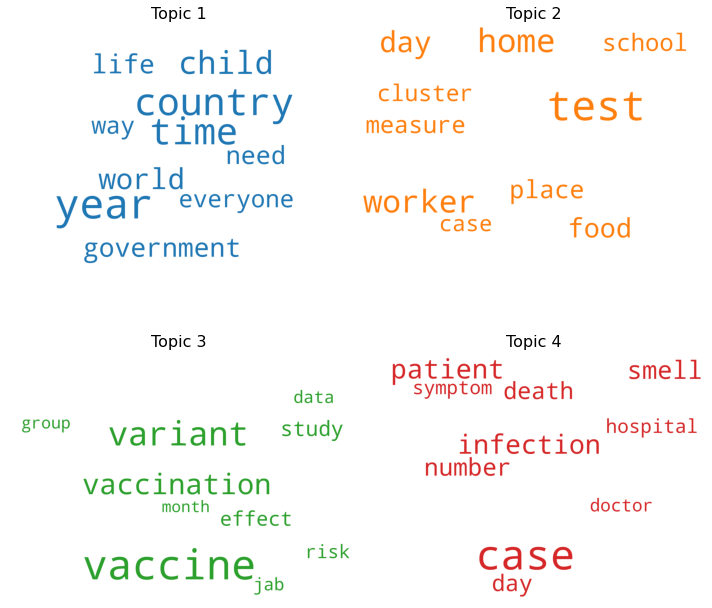

In [70]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=mystopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_4.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [71]:
from collections import Counter
topics = lda_4.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
  for word, weight in topic:
    out.append([word, i , weight, counter[word]])


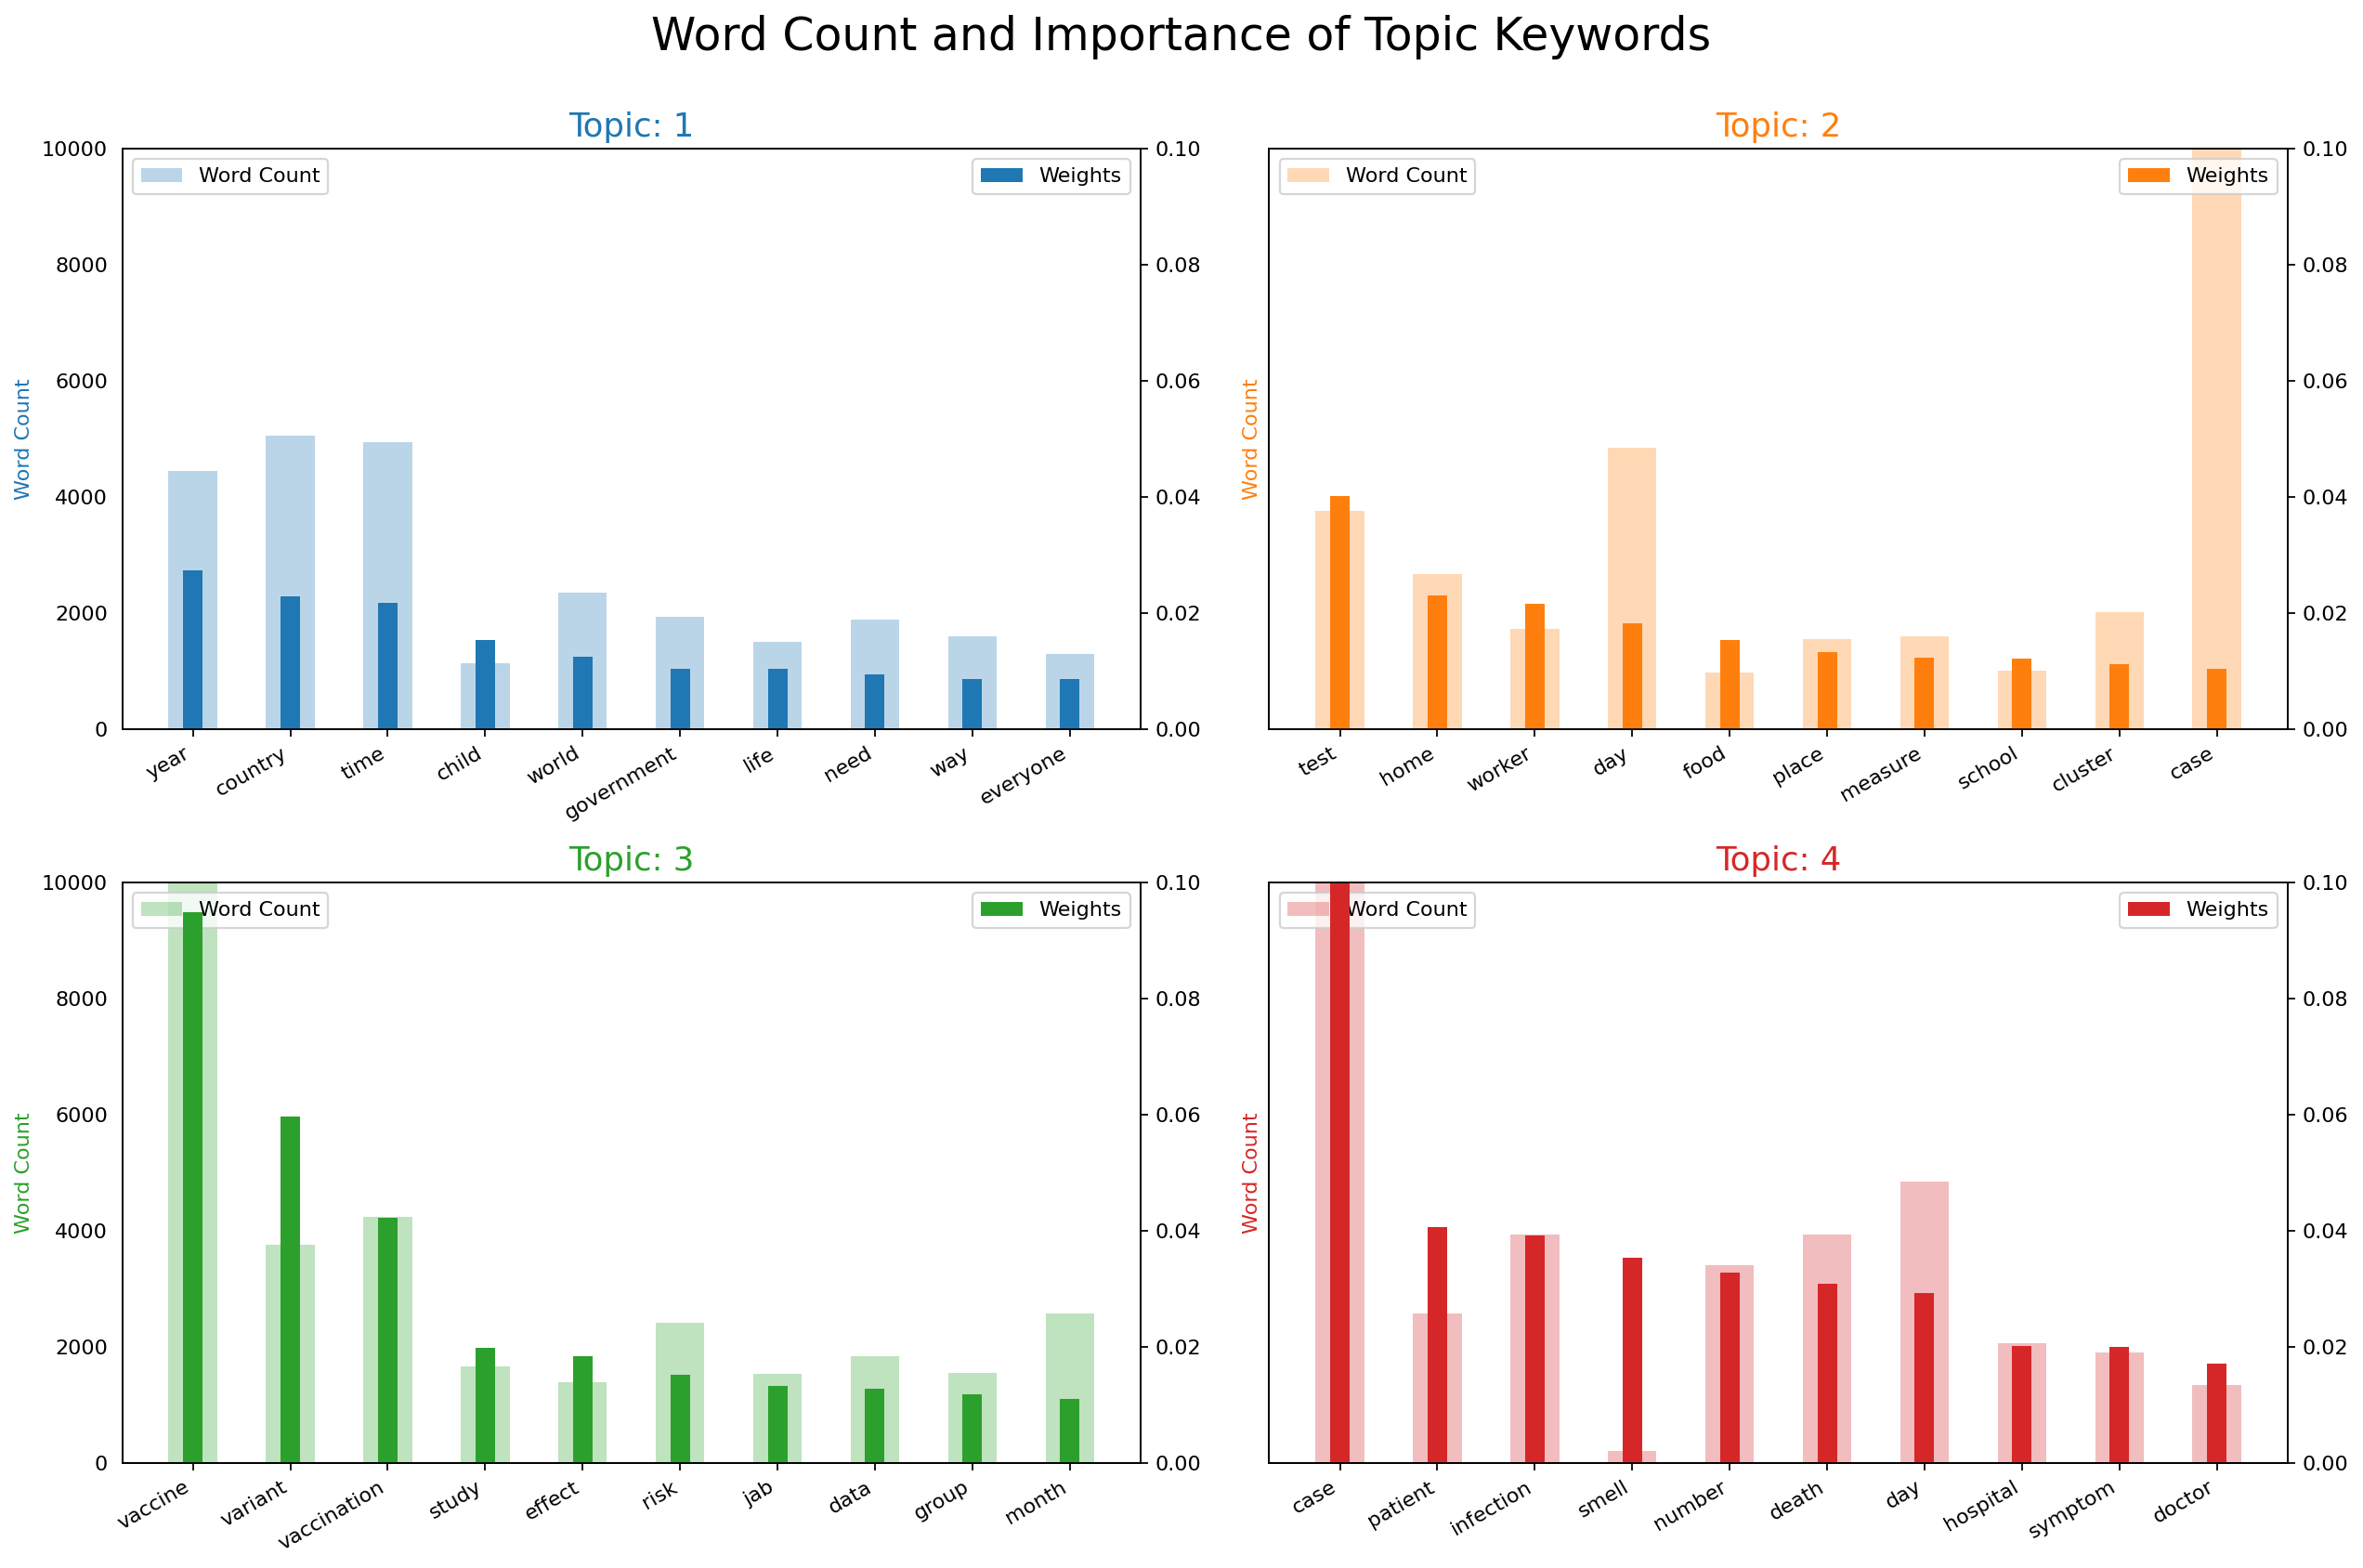

In [73]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i])
  ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 10000)
  ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Modelling for 6 topics

In [74]:
data_ready = tokens
frac = 0.5
num_topics = 6
passes = 5
chunksize = 32
random_state=99

# Use dictionary (built from corpus) to prepare a DTM (using frequency)

#df = dataframe.sample(frac = frac, random_state=random_state)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Filter off any words with document frequency less than 2, or appearing in more than 80% documents
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]

2021-11-23 00:37:17,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:37:18,203 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:37:18,226 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:37:18,243 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('homeland', 9), ('brainwashing', 2), ('granny', 3), ('stubbornness', 6), ('competitor', 8), ('comrade', 7), ('interviewee', 2)]...
2021-11-23 00:37:18,246 : INFO : keeping 1879 tokens which were in no less than 20 and no more than 8478 (=80.0%) documents
2021-11-23 00:37:18,252 : INFO : resulting dictionary: Dictionary(1879 unique tokens: ['business', 'friend', 'report', 'victim', 'woman']...)


In [75]:
lda_6 = gensim.models.ldamodel.LdaModel(dtm, num_topics = num_topics, id2word = dictionary, passes=passes,chunksize=chunksize,random_state=random_state)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
2021-11-23 00:38:26,332 : INFO : -6.449 per-word bound, 87.4 perplexity estimate based on a held-out corpus of 32 documents with 764 words
2021-11-23 00:38:26,334 : INFO : PROGRESS: pass 3, at document #10240/10598
2021-11-23 00:38:26,347 : INFO : merging changes from 32 documents into a model of 10598 documents
2021-11-23 00:38:26,351 : INFO : topic #1 (0.167): 0.056*"test" + 0.040*"home" + 0.029*"day" + 0.027*"cluster" + 0.021*"result" + 0.018*"family" + 0.018*"hospital" + 0.016*"worker" + 0.016*"contact" + 0.015*

Top 10 representative words for 6 topics

In [76]:
lda_6.show_topics(10)

[(0,
  '0.038*"year" + 0.033*"time" + 0.024*"child" + 0.015*"life" + 0.014*"world" + 0.013*"school" + 0.013*"everyone" + 0.013*"report" + 0.012*"way" + 0.011*"country"'),
 (1,
  '0.060*"test" + 0.041*"smell" + 0.033*"home" + 0.028*"day" + 0.027*"worker" + 0.023*"cluster" + 0.017*"hospital" + 0.016*"result" + 0.013*"evidence" + 0.013*"staff"'),
 (2,
  '0.120*"vaccine" + 0.076*"variant" + 0.053*"vaccination" + 0.021*"country" + 0.018*"population" + 0.018*"cent" + 0.017*"jab" + 0.016*"data" + 0.014*"dose" + 0.014*"health"'),
 (3,
  '0.034*"patient" + 0.026*"study" + 0.017*"doctor" + 0.017*"symptom" + 0.017*"effect" + 0.016*"body" + 0.015*"disease" + 0.014*"risk" + 0.014*"drug" + 0.014*"cell"'),
 (4,
  '0.212*"case" + 0.055*"number" + 0.053*"infection" + 0.037*"death" + 0.032*"day" + 0.027*"country" + 0.023*"community" + 0.022*"week" + 0.016*"immunity" + 0.015*"wave"'),
 (5,
  '0.042*"mask" + 0.034*"food" + 0.022*"job" + 0.018*"thing" + 0.017*"driver" + 0.015*"officer" + 0.015*"delivery" +

In [86]:
#  with open('lda_6v2.pickle', 'wb') as handle:
#     pickle.dump(lda_6, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
'''
u_mass:prefer the model close to 0
c_v: [0,1], prefer bigger value
Do not fully rely on the coherence score
'''

from gensim.models.coherencemodel import CoherenceModel

dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=2, no_above=0.8)
"""
          no_below : int, optional
              Keep tokens which are contained in at least `no_below` documents.
          no_above : float, optional
              Keep tokens which are contained in no more than `no_above` documents
              (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in data_ready]


cm_umass = CoherenceModel(lda_6,  dictionary=dictionary, corpus=dtm, coherence='u_mass')
cm_cv = CoherenceModel(lda_6,  dictionary=dictionary, texts=tokens, coherence='c_v')
lda_6_umass = cm_umass.get_coherence()
lda_6_cv = cm_cv.get_coherence()
print(f"u_mass:{lda_6_umass}",'\n\n')
print(f"cv:{lda_6_cv}")

2021-11-23 00:45:03,417 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:45:03,824 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:45:03,849 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:45:03,863 : INFO : discarding 2931 tokens: [('painter', 1), ('striking', 1), ('dow', 1), ('cushion', 1), ('dishwashing', 1), ('fieldwork', 1), ('appeasement', 1), ('aghast', 1), ('bangle', 1), ('punter', 1)]...
2021-11-23 00:45:03,864 : INFO : keeping 6630 tokens which were in no less than 2 and no more than 8478 (=80.0%) documents
2021-11-23 00:45:03,873 : INFO : resulting dictionary: Dictionary(6630 unique tokens: ['business', 'friend', 'report', 'singer', 'victim']...)
2021-11-23 00:45:04,228 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021

u_mass:-8.908555870270321 


cv:0.43811157137575596


##Visualise 6 topics

In [78]:
data_ready = tokens
dictionary = corpora.Dictionary(data_ready)
dictionary.filter_extremes(no_below=20, no_above=0.8)
dtm = [dictionary.doc2bow(d) for d in data_ready]
# Build LDA model

pyLDAvis.enable_notebook()
vis3 = gensimvis.prepare(lda_6, dtm, dictionary=lda_6.id2word)
vis3

2021-11-23 00:45:33,327 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-23 00:45:33,740 : INFO : adding document #10000 to Dictionary(9405 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...)
2021-11-23 00:45:33,764 : INFO : built Dictionary(9561 unique tokens: ['business', 'friend', 'painter', 'report', 'singer']...) from 10598 documents (total 459724 corpus positions)
2021-11-23 00:45:33,784 : INFO : discarding 7682 tokens: [('painter', 1), ('singer', 16), ('charity', 18), ('homeland', 9), ('brainwashing', 2), ('granny', 3), ('stubbornness', 6), ('competitor', 8), ('comrade', 7), ('interviewee', 2)]...
2021-11-23 00:45:33,786 : INFO : keeping 1879 tokens which were in no less than 20 and no more than 8478 (=80.0%) documents
2021-11-23 00:45:33,793 : INFO : resulting dictionary: Dictionary(1879 unique tokens: ['business', 'friend', 'report', 'victim', 'woman']...)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013826 -0.218637       1        1  22.233723
2      0.145288  0.104639       2        1  20.405729
1     -0.062595  0.014610       3        1  16.543229
3      0.136103  0.283687       4        1  16.104104
4      0.146497 -0.227823       5        1  14.747262
5     -0.379120  0.043523       6        1   9.965952, topic_info=            Term          Freq         Total Category  logprob  loglift
78          case  13035.000000  13035.000000  Default  30.0000  30.0000
14       vaccine  10191.000000  10191.000000  Default  29.0000  29.0000
243      variant   6480.000000   6480.000000  Default  28.0000  28.0000
106         test   4179.000000   4179.000000  Default  27.0000  27.0000
107  vaccination   4544.000000   4544.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
233        place    481.415615   1606.350772   Topic6  -4.4602   1.1010
256      company    388.055290   1037.399219   Topic6  -4.6758   1.3227
269        group    424.110143   1660.435713   Topic6  -4.5870   0.9412
92         month    422.616358   3156.403359   Topic6  -4.5905   0.2953
130         need    351.805424   1794.901320   Topic6  -4.7739   0.6764

[327 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1176      3  0.996242    airport
77        4  0.999117   antibody
145       2  0.998424     anyone
214       1  0.957160   anything
214       2  0.038552   anything
...     ...       ...        ...
190       1  0.769276       year
190       2  0.120138       year
190       4  0.087986       year
190       5  0.022377       year
304       1  0.996876  yesterday

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5, 6])

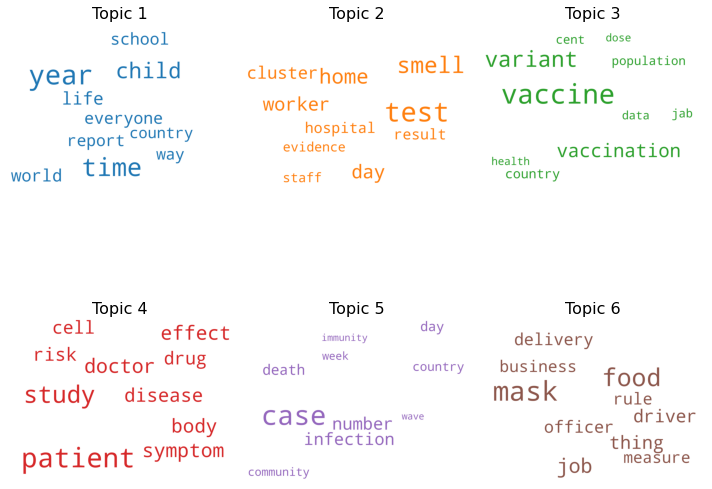

In [80]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=mystopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_6.show_topics(formatted=False)

fig, axes = plt.subplots(2,3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [81]:
data_ready = tokens
from collections import Counter
topics = lda_6.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
  for word, weight in topic:
    out.append([word, i , weight, counter[word]])


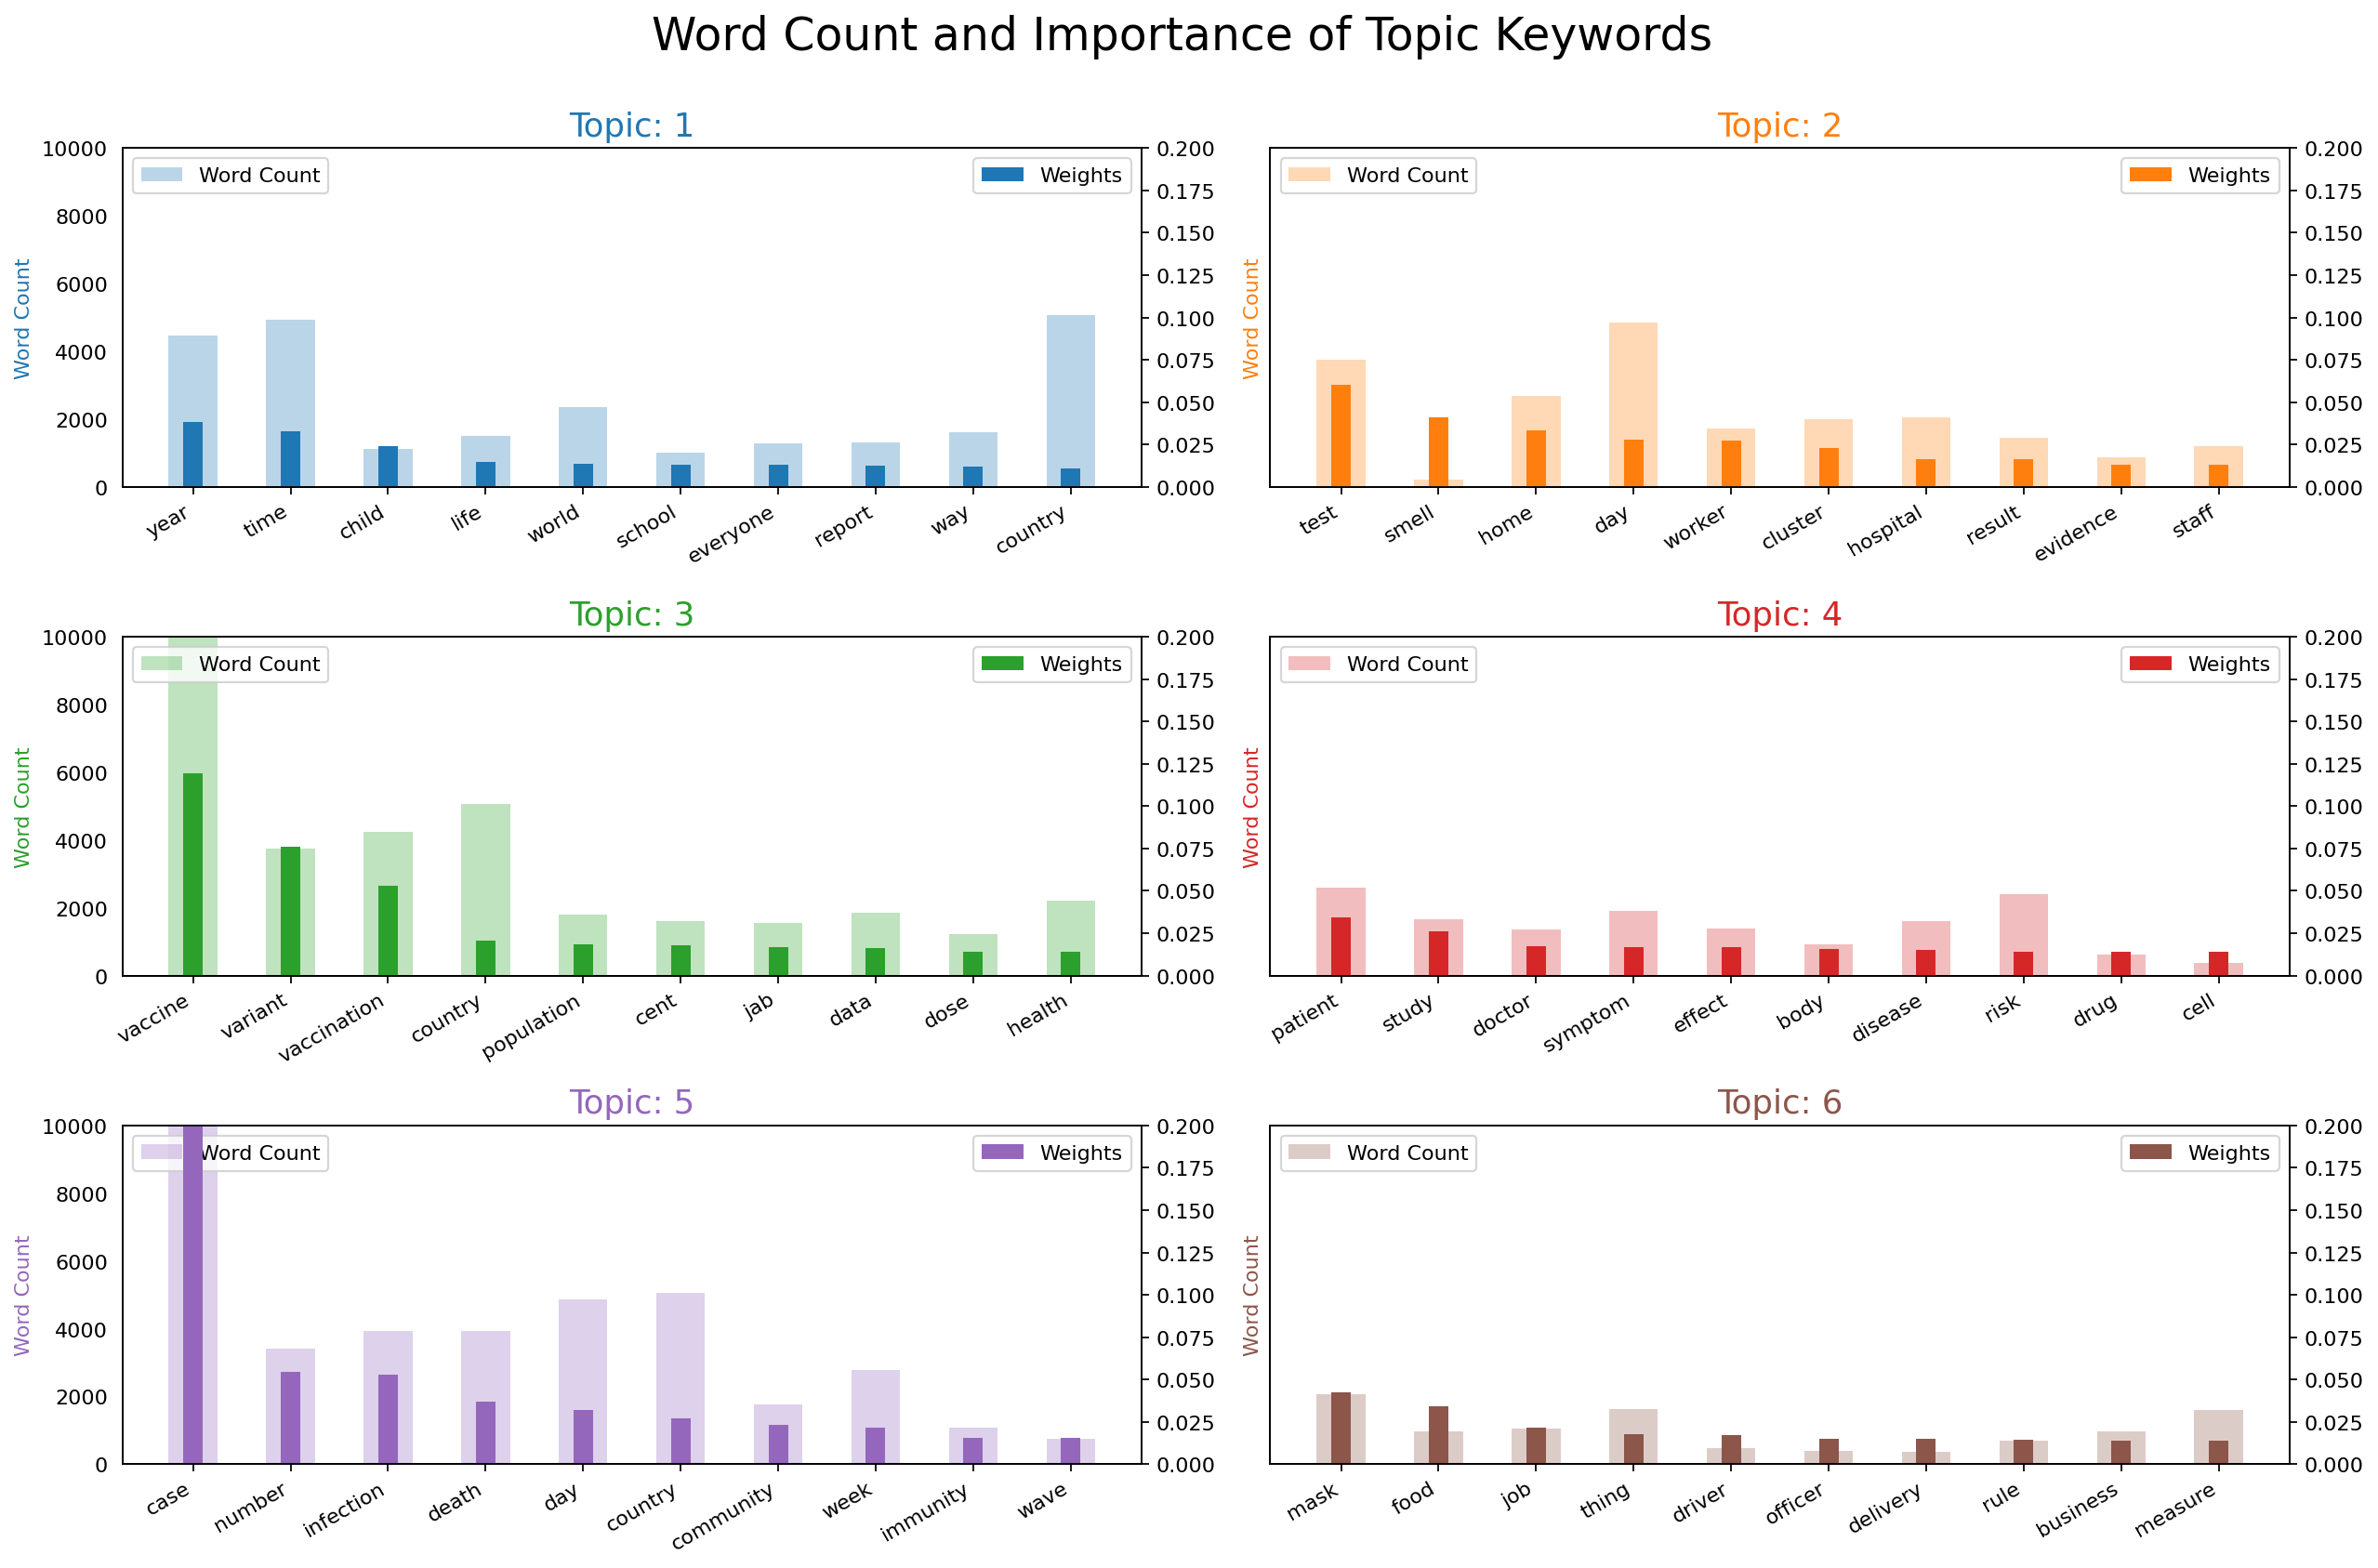

In [82]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i])
  ax_twin.set_ylim(0, 0.20); ax.set_ylim(0, 10000)
  ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Topic modelling references

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#10removestopwordsmakebigramsandlemmatize



https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#11.-Sentence-Chart-Colored-by-Topic

http://frickp.github.io/lda-airline-visualization.html